### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import logging
import subprocess
import os
from datetime import datetime
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingWarmRestarts
import torchvision
from torchvision import models
from apex import amp

from torch_lr_finder import LRFinder

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PROJ_PATH,
                              PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, TilesTrainDataset, LazyTilesDataset, PatchTrainDataset, H5PatchDataset, SeqenceRandomSampler

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix, text_classes_preds)

# Nets
from chestxray.nets import TinyV2ConvNet, freeze_botom, PatchModel, PatchEnetModel, PatchBiTModel, TilesModel, AttentionModel
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)
# Losses
from chestxray.losses import LabelSmoothSoftmaxCEV1, TopkCrossEntropy, TopkBCEWithLogitsLoss

# Optim
from chestxray.optimizers import RAdam

# Schedulers
from chestxray.schedulers import CosineAnnealingWarmUpRestarts

# postproc
from chestxray.postprocess import OptimizedRounder

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Fix Random Seed

In [6]:
seed_torch()

In [7]:
# torch.backends.cudnn.benchmark = True

### Load Data

In [8]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [9]:
TRAIN_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
dtypes: int64(1), object(3)
memory usage: 331.9+ KB


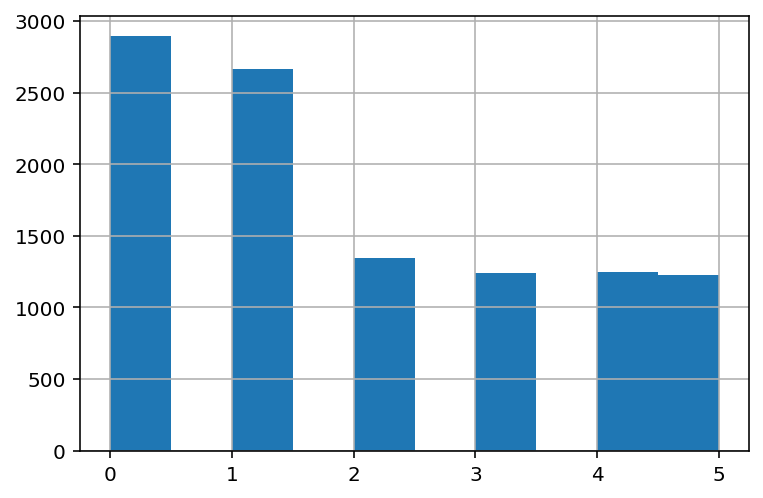

In [10]:
_ = TRAIN_DF[CFG.target_col].hist()

### Define Global Variables

In [11]:
if CFG.debug:
    EXP_NAME = "debug"
    writer = SummaryWriter(f"runs_v1/{EXP_NAME}")
    print(f"Start experiment: {EXP_NAME}")
else:
    if not CFG.resume:
        now = datetime.now()
        EXP_NAME = now.strftime("%d-%m-%Y-%H-%M")
        print(f"Start experiment: {EXP_NAME}")

        writer = SummaryWriter(f"runs_v1/{EXP_NAME}")
    else:
        # if resume should define from what to start
        PREV_NAME = CFG.prev_exp
        writer = SummaryWriter(f"runs_v1/{PREV_NAME}_{CFG.stage}")

Start experiment: debug


In [12]:
# Set logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

log_format = logging.Formatter('%(message)s')
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(log_format)
logger.handlers = [stream_handler]
# add logging handler to save training to the file
log_fname = f"{PROJ_PATH/'logs'}/{EXP_NAME}.log"
file_handler = logging.FileHandler(log_fname, mode="a")
file_handler.setFormatter(log_format)
logger.handlers.append(file_handler)

In [13]:
LOSSES = {
    "cce" : nn.CrossEntropyLoss(),
    "mse" : nn.MSELoss(),
    "ls_soft_ce" : LabelSmoothSoftmaxCEV1(),
    "ohem" : TopkCrossEntropy(),
    "bce" : TopkBCEWithLogitsLoss() if CFG.ohem else nn.BCEWithLogitsLoss(),
}

In [14]:
# key - string, value - tuple(sceduler, if it epoch type)
epoch_type = True
SCHEDULERS = {
    "reduce_on_plateau" : (ReduceLROnPlateau, epoch_type),
    "one_cycle": (OneCycleLR, not epoch_type),
    "cawr": (CosineAnnealingWarmUpRestarts, not epoch_type),
    "none": (None, None)
}

In [15]:
# schedulers
def get_scheduler(optimizer,train_dataloader, schedule_type=CFG.schedule_type, resume=False):
    assert schedule_type in SCHEDULERS, f"{schedule_type} not in SCHEDULERS"
    if schedule_type == "reduce_on_plateau":
        return (SCHEDULERS[schedule_type][0](optimizer, 'min', factor=0.5, patience=CFG.rlopp if not resume else CFG.rlopp + 2, verbose=True), 
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "one_cycle":
        return (SCHEDULERS[schedule_type][0](optimizer, max_lr=[CFG.lr, CFG.lr*10] if CFG.finetune == "1stage" else CFG.lr,
                                             steps_per_epoch=int(len(train_dataloader) / CFG.accum_step), epochs=CFG.epoch, pct_start=1/CFG.epoch, 
                                             cycle_momentum=False, final_div_factor=CFG.oc_final_div_factor),
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "cawr":
        return (SCHEDULERS[schedule_type][0](optimizer, T_0=CFG.cawr_T_0, T_mult=CFG.cawr_T_mult, eta_max=CFG.lr, T_up=CFG.cawr_T_up, gamma=CFG.cawr_gamma),
                SCHEDULERS[schedule_type][1])
    else:
        return (SCHEDULERS[schedule_type][0],
                SCHEDULERS[schedule_type][1])

### Train Eval Loop

In [16]:
# Train Eval Loop
def train_eval_loop(
    train_dataloader,
    val_dataloader,
    model,
    optimizer,
    criterion,
    accum_step=CFG.accum_step,
    checkpoint=False,
    num_epochs=CFG.epoch,
    device=device,
    tb_tag="",
    model_name="debug",
):
    """Split it into the set of inner functions to siplify the loop itself"""
    # Inner Functions
    # write to TensorBoard helpers
    def weights_to_tb(step=0):
        conv1_weight = list(model.parameters())[0].data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight.float(), normalize=True)
        writer.add_image(
            tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=step
        )

    def input_img_to_tb(inputs, step):
        img = reverse_show_img(inputs[0], denorm=True)
        writer.add_image(
            tag=f"Input Image {tb_tag}",
            img_tensor=img,
            global_step=step,
            dataformats="HWC",
        )
        del img

    def preds_to_tb(outputs, inputs, labels, step):
        figure = plot_classes_preds(
            outputs.to("cpu"), inputs.to("cpu"), labels.to("cpu")
        )
        writer.add_figure(
            tag=f"Actuals vs Predictions {tb_tag}", figure=figure, global_step=step
        )

    def text_preds_to_tb(outputs, labels, step):
        preds, targs = compute_preds(outputs, labels)
        preds_text = f"targs: {targs}, preds: {preds}"
        writer.add_text(
            f"Actuals vs Predictions {tb_tag}", preds_text, global_step=step
        )

    def metrics_to_tb(mode, train_loss, train_score, val_loss, val_score, step):
        writer.add_text(
            f"On best {mode} save:",
            f"tr_loss: {train_loss:.4f}, tr_qwk: {train_score:.4f}, val_loss: {val_loss:.4f}, val_qwk: {val_score:.4f}",  # noqa
            global_step=step,
        )

    def conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, step):
        writer.add_figure(
            tag=f"Confusion matrix {tb_tag}",
            figure=plot_confusion_matrix(
                val_epoch_labels, val_epoch_preds, normalize=True
            ),
            global_step=step,
        )
        
    def attention_to_tb(att, step):
        att_arr = att.data.cpu().numpy()[0, 0]
        text = f"{np.around(att_arr, decimals=3)}"
        writer.add_text(f"Attention Map for Oth Val sample {tb_tag}", text, global_step=step)
        
        
    def compute_preds(outputs, labels, loss_type=CFG.loss):
        if loss_type == "bce":
            preds = outputs.detach().sigmoid().sum(1).round()
            targs = labels.sum(1)
        elif loss_type == "mse":
            preds = outputs.detach().round()
            targs = labels
        else:
            preds = outputs.detach().argmax(1)
            targs = labels
        return preds.int(), targs.int()
        

    # Train/Eval Loop
    # write first layer weights to TB @ init phase
    if not CFG.debug:
        weights_to_tb()

    # prepare model and optimizer
    model.to(device)
    if CFG.use_amp:  # automatic mixed precision
        model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
        
    # init scheduler after amp init of optimizer
    scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader, resume=CFG.resume)
    
    # define epochs numbers to look into input images and predictions,
    # no more than 30 times per full training
    vis_step = np.ceil(num_epochs / 30).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    # metrics to wathch for model checkpointing
    best_qwk = -100 if not checkpoint else checkpoint["best_qwk"]
    best_val_loss = np.inf if not checkpoint else checkpoint["best_val_loss"]

    start_epoch = 0 if not checkpoint else checkpoint["epoch"] + 1
    for epoch in range(start_epoch, num_epochs):
        logging.info(f"Epoch {epoch}/{num_epochs - 1}")
        logging.info("=" * 10)

        # Training Phase
        # Set training mode
        model.train()
        train_running_loss = 0.0
        accum_train_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []

        # We accumulate, zero at training epoch begins
        optimizer.zero_grad()

        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step for TensorBoard
            train_global_step = epoch * len(train_dataloader) + i

            inputs, labels = data
            # Visualize input before model at the middle of epoch:
            if epoch in visual_epochs and i == len(train_dataloader) // 2:
                input_img_to_tb(inputs, train_global_step)

            inputs = inputs.to(device)
            labels = labels.to(device)

            if CFG.att:
                outputs, _ = model(inputs) # don't need att map here
            else:
                outputs = model(inputs)
            
            # then usimg accumulated gradients they sum up every loss.backward, we want mean of gradients
            # and so pararameter updates will be the same in case of accum_step > 1
            loss = criterion(outputs, labels) / accum_step
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            
            accum_train_loss += loss.item()
            # we accumulate gradients and make optimization step once per
            # # of accum_step
            if (i + 1) % accum_step == 0:
                optimizer.step()
                optimizer.zero_grad()
                # Add Batch Type Scheduler step here (update lr only after optimizer step):
                if scheduler and not sch_is_epoch_type:
                    if CFG.schedule_type == "cawr":
                        scheduler.step(epoch + i / len(train_dataloader))
                    else:
                        scheduler.step()

                # loss is mean across batch, divide by number of steps in epoch
                # (so loss is normalized) + we only update train_running_loss every accum_step
                train_running_loss += accum_train_loss / (len(train_dataloader) / accum_step)
                # tensorboarding loss
                writer.add_scalar(
                    tag=f"Training loss {tb_tag}",
                    scalar_value=accum_train_loss,
                    global_step=train_global_step,
                )
                # zero accum_train_loss 
                accum_train_loss = 0.

            # collect train preds and labels for QWK
            preds, targs = compute_preds(outputs, labels)
            train_epoch_preds.append(preds)
            train_epoch_labels.append(targs)
            
        # Validation Phase
        # Set evaluation mode
        model.eval()
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            if CFG.aux_tile:
                inp_main, inp_aux = inputs
                inp_main, inp_aux = inp_main.to(device), inp_aux.to(device)
            else:
                inputs = inputs.to(device)
            
            labels = labels.to(device)
            with torch.no_grad():
                if CFG.aux_tile:
                    out_main = model(inp_main)
                    out_aux = model(inp_aux)
                    outputs = (out_main + out_aux) / 2
                else:
                    if CFG.att:
                        outputs, att = model(inputs)
                    else:
                        outputs = model(inputs)
            if CFG.ohem:
                loss = criterion(outputs, labels, valid=True)
            else:
                loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(
                tag=f"Validation loss {tb_tag}",
                scalar_value=loss.item(),
                global_step=val_global_step,
            )

            # collect validation preds and labels for QWK
            preds, targs = compute_preds(outputs, labels)
            val_epoch_preds.append(preds)
            val_epoch_labels.append(targs)

            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                text_preds_to_tb(outputs, labels, val_global_step)
                
                # look into attention map if use it
                if CFG.att:
                    attention_to_tb(att, val_global_step)

        # Epoch type Schedulers
        if scheduler and sch_is_epoch_type:
            scheduler.step(val_running_loss)
        # Write lr to TBD
        if CFG.finetune == "1stage":
            writer.add_scalar(
                tag=f"lr Interim {tb_tag}:",
                scalar_value=optimizer.param_groups[0]["lr"],
                global_step=train_global_step,
            )
            writer.add_scalar(
                tag=f"lr Classifier {tb_tag}:",
                scalar_value=optimizer.param_groups[1]["lr"],
                global_step=train_global_step,
            )

        else:
            writer.add_scalar(
                tag=f"lr {tb_tag}:",
                scalar_value=optimizer.param_groups[0]["lr"],
                global_step=train_global_step,
            )

        # "End of Epoch" Phase
        logging.info(
            f"Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}"  # noqa
        )

        # Calculate epoch predictions distribution
        train_epoch_preds = torch.cat(train_epoch_preds).cpu().numpy()
        train_epoch_labels = torch.cat(train_epoch_labels).cpu().numpy()
        val_epoch_preds = torch.cat(val_epoch_preds).cpu().numpy()
        val_epoch_labels = torch.cat(val_epoch_labels).cpu().numpy()
        logging.info(
            f"Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}"  # noqa
        )
        # Calculate epoch QWK
        train_qwk = cohen_kappa_score(
            train_epoch_preds, train_epoch_labels, weights="quadratic"
        )
        val_qwk = cohen_kappa_score(
            val_epoch_preds, val_epoch_labels, weights="quadratic"
        )
        logging.info(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(
            tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch
        )
        writer.add_scalar(
            tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch
        )

        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            logging.info(f"  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_val_loss": best_val_loss,
                    "best_qwk": val_qwk,
                },
                f"{MODEL_PATH}/{model_name}_{epoch}_loss.pth",
            )
            # add losses as text to TB
            metrics_to_tb(
                "loss",
                train_running_loss,
                train_qwk,
                val_running_loss,
                val_qwk,
                val_global_step,
            )
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
            
        # On the best val loss do:
        if val_qwk > best_qwk:
            # update best and save model
            best_qwk = val_qwk
            logging.info(f"  Epoch {epoch} - Save Best QWK: {best_qwk:.4f} Model")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_val_loss": val_running_loss,
                    "best_qwk": best_qwk,
                },
                f"{MODEL_PATH}/{model_name}_{epoch}_qwk.pth",
            )
            # add losses as text to TB
            metrics_to_tb(
                "qwk",
                train_running_loss,
                train_qwk,
                val_running_loss,
                val_qwk,
                val_global_step,
            )
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
        
        # maybe it helps!
#         torch.cuda.empty_cache()

    # End of loop
    return model, best_val_loss, best_qwk

### Prepare CV - strategy

In [17]:
CFG.debug = True

In [17]:
# That for the first time

In [28]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=500, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [16]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

NameError: name 'folds_fn' is not defined

In [17]:
# Here use existing (folds_dedup is folds_cleaned + dropped duplicates)
# See corresponding notebooks: Suspicious_Input for cleaning
# and Find_Drop_Duplicates for duplicates

In [18]:
if CFG.debug:
    folds = pd.read_csv(PANDA_PATH/"folds_db.csv")
else:
    folds = pd.read_csv(PANDA_PATH/"folds_dedup_v1.csv")

In [19]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       500 non-null    object
 1   data_provider  500 non-null    object
 2   isup_grade     500 non-null    int64 
 3   gleason_score  500 non-null    object
 4   fold           500 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 19.7+ KB


In [20]:
folds = folds.sample(20)

### Init Data

In [21]:
# get folds (all experiments validated on fold 0)
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()

# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False, aux_tile=CFG.aux_tile, regression=CFG.regression, loss=CFG.loss)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False, aux_tile=CFG.aux_tile, regression=CFG.regression, loss=CFG.loss)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = PatchTrainDataset(val_df, is_train=False, debug=False)
elif CFG.dataset == "hdf5":
    train_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_1.h5", "patch256x16x1_fold_2.h5", "patch256x16x1_fold_3.h5"])
    val_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_0.h5"])
else:
    print(f"No such dataset {CFG.dataset}")
    
# define a data loader
if CFG.dataset == "hdf5":
    # use specific sampler (so not to load hdf5 files to memory too frequently)
    sampler = SeqenceRandomSampler(len(train_ds), train_ds._common_len)
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, sampler=sampler, num_workers=min(CFG.batch_size, 8), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size, 8), pin_memory=True)
else:
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size+2, 6), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size+2, 6), pin_memory=False)

### Init Functions

In [22]:
def init_model(train_df=train_df, arch=CFG.arch, pre_init_fc_bias=CFG.pre_init_fc_bias, pretrained=True):
    # For now only torchvision models ok for attention
    if CFG.att:
        assert arch in ["resnet50", "resnet34"]
    
    # MIL variant
    if CFG.dataset == "patch":
        if arch == "efnet":
            model_ft = PatchEnetModel(backbone=CFG.enet_bone, pretrained=pretrained)
        elif arch == "bitM":
            model_ft = PatchBiTModel(pretrained=pretrained)
        else:
            if CFG.att:
                model_ft = AttentionModel(arch=arch, pretrained=pretrained)
            else:
                model_ft = PatchModel(arch=arch, pretrained=pretrained)
            if pre_init_fc_bias:
                if CFG.loss in ["cce", "ls_soft_ce", "ohem"]:
                    # initialize bias in the model
                    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
                    model_ft = init_last_layer_bias(model_ft, cls_probas)
    # Stitched Tiles variant
    elif CFG.dataset == "tiles":
        if arch in ["resnet50", "resnet34"]:
            model_ft = TilesModel(arch=arch, pretrained=pretrained, loss=CFG.loss, regression=CFG.regression)
        else:
            print(f"Tiles model for {arch} is not yet implemented!")
    
    return model_ft


def init_optimizer(model_ft):
    if CFG.finetune == "1stage":
        freeze_botom(model_ft)
        interm_params = [
            p[1]
            for p in model_ft.named_parameters()
            if (not p[0].startswith("fc") and p[1].requires_grad)
        ]
        if CFG.optim == "adam":
            optimizer = torch.optim.Adam(
                [
                    {"params": interm_params, "lr": CFG.lr},
                    {"params": model_ft.fc.parameters(), "lr": CFG.lr * 10},
                ]
            )
        elif CFG.optim == "sgd":
            optimizer = torch.optim.SGD(
                [
                    {"params": interm_params, "lr": CFG.lr},
                    {"params": model_ft.fc.parameters(), "lr": CFG.lr * 10},
                ],
                momentum=0.9,
                nesterov=True,
            )
    else:
        LR = CFG.lr / 1000 if CFG.schedule_type == "cawr" else CFG.lr
        if CFG.optim == "adam":
            optimizer = torch.optim.Adam(
                model_ft.parameters(), lr=LR, amsgrad=False
            )
        elif CFG.optim == "adamw":
            optimizer = torch.optim.AdamW(model_ft.parameters(), lr=LR, 
                                          weight_decay=CFG.wd)
        elif CFG.optim == "sgd":
            optimizer = torch.optim.SGD(
                model_ft.parameters(), lr=LR, momentum=0.9, nesterov=True
            )
        elif CFG.optim == "radam":
            optimizer = RAdam(model_ft.parameters(), lr=LR)

    return optimizer

criterion = LOSSES[CFG.loss]

### Debug Runs

In [23]:
print(" ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: True seed: 1982 img_height: 224 img_width: 224 target_size: 6 img_id_col: image_id target_col: isup_grade tiff_layer: 1 stoch_sample: True num_tiles: 36 tile_sz: 224 batch_size: 8 accum_step: 1 dataset: tiles aux_tile: False aux_tile_sz: 0 aux_tile_num: 0 aug_type: light regression: True att: False arch: resnet34 enet_bone: efficientnet-b0 finetune: False model_cls: deep pre_init_fc_bias: False ohem: False loss: mse optim: adamw lr: 3e-05 wd: 0.0 schedule_type: none oc_final_div_factor: 10.0 cawr_T_0: 10 cawr_T_mult: 2 cawr_T_up: 3 cawr_gamma: 0.8 rlopp: 1 resume: False prev_exp: None from_epoch: 0 stage: 0 epoch: 45 n_fold: 4 use_amp: True descript: bce-ohem + rn34 + 224x36 tiles + OC + weighted data


In [24]:
logging.info(f'Start: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')
model_ft = init_model()
optimizer = init_optimizer(model_ft)
    
scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader)

_ = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, num_epochs=35)
logging.info(f'Finish: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')

Start: 04-07-2020-20-35
Epoch 0/34


Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


 50%|█████     | 1/2 [00:01<00:01,  1.94s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 2/2 [00:03<00:00,  1.65s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
Training Loss: 3.5146	Validation Loss: 2.1982
Counter train preds: Counter({3: 10, 2: 6})	Counter val preds: Counter({2: 3, 1: 1})
Epoch train QWK: -0.021	val QWK: 0.385
  Epoch 0 - Save Best Loss: 2.1982 Model
/home/ademyanchuk/Projects/ChestXRay/chestxray/visualize.py:155: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  Epoch 0 - Save Best QWK: 0.3846 Model


Normalized confusion matrix
[[ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [nan nan nan nan]
 [ 0.  0.  1.  0.]]


Epoch 1/34


Normalized confusion matrix
[[ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [nan nan nan nan]
 [ 0.  0.  1.  0.]]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
Training Loss: 3.4604	Validation Loss: 2.1138
Counter train preds: Counter({3: 11, 2: 5})	Counter val preds: Counter({2: 3, 1: 1})
Epoch train QWK: 0.076	val QWK: 0.385
  Epoch 1 - Save Best Loss: 2.1138 Model
Epoch 2/34


Normalized confusion matrix
[[ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [nan nan nan nan]
 [ 0.  0.  1.  0.]]


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
Training Loss: 3.0892	Validation Loss: 2.0689
Counter train preds: Counter({3: 10, 2: 6})	Counter val preds: Counter({2: 2, 3: 1, 1: 1})
Epoch train QWK: 0.113	val QWK: 0.167
  Epoch 2 - Save Best Loss: 2.0689 Model
Epoch 3/34


Normalized confusion matrix
[[0.  1.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0. ]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [0.  0.  1.  0.  0. ]]


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
Training Loss: 2.9369	Validation Loss: 2.0173
Counter train preds: Counter({3: 10, 2: 6})	Counter val preds: Counter({2: 2, 3: 1, 1: 1})
Epoch train QWK: 0.314	val QWK: 0.167
  Epoch 3 - Save Best Loss: 2.0173 Model
Epoch 4/34


Normalized confusion matrix
[[0.  1.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0. ]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [0.  0.  1.  0.  0. ]]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
Training Loss: 2.3764	Validation Loss: 1.9679
Counter train preds: Counter({2: 9, 3: 7})	Counter val preds: Counter({2: 2, 3: 1, 1: 1})
Epoch train QWK: 0.405	val QWK: 0.167
  Epoch 4 - Save Best Loss: 1.9679 Model
Epoch 5/34


Normalized confusion matrix
[[0.  1.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0. ]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [0.  0.  1.  0.  0. ]]


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
Training Loss: 2.0838	Validation Loss: 1.7719
Counter train preds: Counter({3: 9, 2: 5, 1: 2})	Counter val preds: Counter({2: 3, 1: 1})
Epoch train QWK: 0.411	val QWK: 0.385
  Epoch 5 - Save Best Loss: 1.7719 Model
Epoch 6/34


Normalized confusion matrix
[[ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [nan nan nan nan]
 [ 0.  0.  1.  0.]]


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
Training Loss: 2.2472	Validation Loss: 1.6648
Counter train preds: Counter({3: 9, 2: 5, 1: 1, 4: 1})	Counter val preds: Counter({2: 3, 1: 1})
Epoch train QWK: 0.420	val QWK: 0.385
  Epoch 6 - Save Best Loss: 1.6648 Model
Epoch 7/34


Normalized confusion matrix
[[ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [nan nan nan nan]
 [ 0.  0.  1.  0.]]


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
Training Loss: 1.6982	Validation Loss: 1.6867
Counter train preds: Counter({2: 7, 3: 5, 4: 3, 1: 1})	Counter val preds: Counter({2: 3, 1: 1})
Epoch train QWK: 0.601	val QWK: 0.385
Epoch 8/34
100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
Training Loss: 1.6647	Validation Loss: 1.7778
Counter train preds: Counter({2: 7, 3: 6, 4: 2, 1: 1})	Counter val preds: Counter({2: 2, 3: 1, 1: 1})
Epoch train QWK: 0.568	val QWK: 0.667
  Epoch 8 - Save Best QWK: 0.6667 Model
Epoch 9/34


Normalized confusion matrix
[[ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [ 0.  0.  0.  1.  0.]]


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
Training Loss: 1.3790	Validation Loss: 1.7448
Counter train preds: Counter({2: 5, 3: 5, 4: 3, 1: 3})	Counter val preds: Counter({3: 2, 2: 1, 1: 1})
Epoch train QWK: 0.643	val QWK: 0.500
Epoch 10/34
100%|██████████| 1/1 [00:00<00:00,  1.86it/s]
Training Loss: 1.2459	Validation Loss: 1.7717
Counter train preds: Counter({2: 6, 4: 5, 1: 3, 3: 2})	Counter val preds: Counter({3: 2, 2: 1, 1: 1})
Epoch train QWK: 0.760	val QWK: 0.500
Epoch 11/34
100%|██████████| 1/1 [00:00<00:00,  2.05it/s]
Training Loss: 1.1314	Validation Loss: 1.8888
Counter train preds: Counter({2: 8, 4: 3, 3: 3, 5: 1, 0: 1})	Counter val preds: Counter({3: 2, 2: 1, 1: 1})
Epoch train QWK: 0.730	val QWK: 0.500
Epoch 12/34
100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
Training Loss: 0.9647	Validation Loss: 1.9763
Counter train preds: Counter({2: 6, 4: 5, 1: 3, 3: 2})	Counter val preds: Counter({3: 2, 2: 1, 1: 1})
Epoch train QWK: 0.786	val QWK: 0.500
Epoch 13/34
100%|██████████| 1

### Experiment Run

#### Learning Rate Finder

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic



Learning rate search finished. See the graph with {finder_name}.plot()


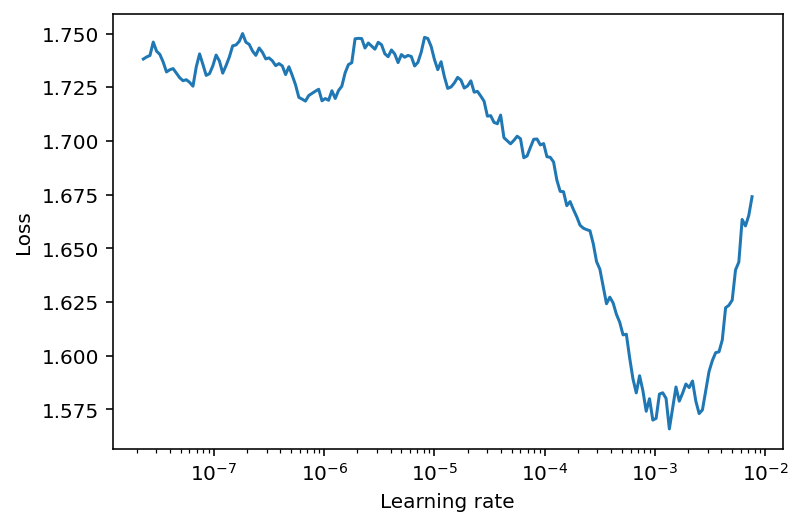

In [17]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size, 10), pin_memory=True)

model_ft = Model(arch="resnet34")
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)
model_ft.to(device)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr * 1e-4, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr * 1e-4, momentum=0.9, nesterov=True)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr * 1e-4)
    
if CFG.use_amp:
    model_ft, optimizer = amp.initialize(model_ft, optimizer, opt_level='O1')
    
lr_finder = LRFinder(model_ft, optimizer, criterion, device=device)
lr_finder.range_test(train_dataloader, end_lr=1e-2, num_iter=200, step_mode="exp", accumulation_steps=CFG.accum_step)
lr_finder.plot()
lr_finder.reset()

#### Experiment

In [22]:
print(" ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False
 seed: 1982
 img_height: 224
 img_width: 224
 target_size: 6
 img_id_col: image_id
 target_col: isup_grade
 tiff_layer: 1
 stoch_sample: True
 num_tiles: 36
 tile_sz: 224
 batch_size: 8
 accum_step: 1
 dataset: tiles
 aux_tile: False
 aux_tile_sz: 0
 aux_tile_num: 0
 aug_type: light
 att: False
 arch: resnet34
 enet_bone: efficientnet-b0
 finetune: False
 model_cls: one_layer
 pre_init_fc_bias: False
 ohem: True
 loss: bce
 optim: radam
 lr: 0.0003
 wd: 0.01
 schedule_type: one_cycle
 oc_final_div_factor: 10.0
 cawr_T_0: 10
 cawr_T_mult: 2
 cawr_T_up: 3
 cawr_gamma: 0.8
 rlopp: 1
 resume: False
 prev_exp: None
 from_epoch: 0
 stage: 0
 epoch: 45
 n_fold: 4
 use_amp: True
 descript: bce-ohem + rn34 + 224x36 tiles + OC + weighted data



In [23]:
writer.add_text("Experiment Description:", CFG.descript)

In [24]:
model_ft = init_model()
optimizer = init_optimizer(model_ft)

In [25]:
logging.info(f'Start: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')
# Start Train/Eval Experiment
model_ft, best_loss, best_qwk = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, model_name=EXP_NAME)
logging.info(f'Finish: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')

Start: 03-07-2020-20-19
Epoch 0/44


Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


  0%|          | 0/936 [00:00<?, ?it/s]/home/ademyanchuk/.cache/pypoetry/virtualenvs/chestxray-uNc73CMC-py3.7/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 1/936 [00:03<1:01:55,  3.97s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


  0%|          | 2/936 [00:04<46:13,  2.97s/it]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.6817	Validation Loss: 0.3928
Counter train preds: Counter({2: 2554, 1: 2166, 3: 1748, 4: 732, 0: 224, 5: 58})	Counter val preds: Counter({2: 933, 1: 666, 3: 553, 4: 253, 5: 90, 0: 6})
Epoch train QWK: 0.440	val QWK: 0.617
  Epoch 0 - Save Best Loss: 0.3928 Model
  Epoch 0 - Save Best QWK: 0.6173 Model


Normalized confusion matrix
[[0.00842697 0.63483146 0.30898876 0.04353933 0.00280899 0.00140449]
 [0.         0.24050633 0.63132911 0.125      0.00316456 0.        ]
 [0.         0.08598726 0.49363057 0.39171975 0.02866242 0.        ]
 [0.         0.06271777 0.24390244 0.47038328 0.19512195 0.02787456]
 [0.         0.03146853 0.21328671 0.3951049  0.26223776 0.0979021 ]
 [0.         0.02962963 0.1037037  0.26666667 0.4037037  0.1962963 ]]


Epoch 1/44


Normalized confusion matrix
[[0.00842697 0.63483146 0.30898876 0.04353933 0.00280899 0.00140449]
 [0.         0.24050633 0.63132911 0.125      0.00316456 0.        ]
 [0.         0.08598726 0.49363057 0.39171975 0.02866242 0.        ]
 [0.         0.06271777 0.24390244 0.47038328 0.19512195 0.02787456]
 [0.         0.03146853 0.21328671 0.3951049  0.26223776 0.0979021 ]
 [0.         0.02962963 0.1037037  0.26666667 0.4037037  0.1962963 ]]


100%|██████████| 313/313 [02:21<00:00,  2.21it/s]
Training Loss: 0.4935	Validation Loss: 0.3440
Counter train preds: Counter({1: 2740, 2: 1874, 3: 1195, 4: 913, 0: 596, 5: 164})	Counter val preds: Counter({1: 1172, 0: 404, 2: 392, 3: 263, 4: 174, 5: 96})
Epoch train QWK: 0.672	val QWK: 0.715
  Epoch 1 - Save Best Loss: 0.3440 Model
  Epoch 1 - Save Best QWK: 0.7151 Model


Normalized confusion matrix
[[0.46348315 0.51544944 0.01544944 0.00421348 0.00140449 0.        ]
 [0.08386076 0.8085443  0.10759494 0.         0.         0.        ]
 [0.02866242 0.52866242 0.36624204 0.06369427 0.01273885 0.        ]
 [0.02090592 0.18466899 0.30313589 0.32055749 0.15679443 0.01393728]
 [0.00699301 0.17132867 0.25174825 0.27272727 0.1958042  0.1013986 ]
 [0.01481481 0.0962963  0.14444444 0.25925926 0.25185185 0.23333333]]


Epoch 2/44


Normalized confusion matrix
[[0.46348315 0.51544944 0.01544944 0.00421348 0.00140449 0.        ]
 [0.08386076 0.8085443  0.10759494 0.         0.         0.        ]
 [0.02866242 0.52866242 0.36624204 0.06369427 0.01273885 0.        ]
 [0.02090592 0.18466899 0.30313589 0.32055749 0.15679443 0.01393728]
 [0.00699301 0.17132867 0.25174825 0.27272727 0.1958042  0.1013986 ]
 [0.01481481 0.0962963  0.14444444 0.25925926 0.25185185 0.23333333]]


 17%|█▋        | 156/936 [01:23<06:37,  1.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.4569	Validation Loss: 0.3572
Counter train preds: Counter({1: 2661, 2: 1779, 3: 1145, 4: 909, 0: 774, 5: 214})	Counter val preds: Counter({1: 1097, 0: 578, 2: 408, 3: 218, 4: 169, 5: 31})
Epoch train QWK: 0.715	val QWK: 0.668
Epoch 3/44
100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.4275	Validation Loss: 0.2902
Counter train preds: Counter({1: 2634, 2: 1745, 3: 1063, 4: 962, 0: 841, 5: 237})	Counter val preds: Counter({1: 935, 2: 610, 3: 326, 4: 289, 0: 204, 5: 137})
Epoch train QWK: 0.747	val QWK: 0.761
  Epoch 3 - Save Best Loss: 0.2902 Model
  Epoch 3 - Save Best QWK: 0.7614 Model


Normalized confusion matrix
[[0.26966292 0.60393258 0.10814607 0.01404494 0.00421348 0.        ]
 [0.01582278 0.59177215 0.35443038 0.03797468 0.         0.        ]
 [0.         0.2388535  0.51910828 0.18789809 0.05414013 0.        ]
 [0.         0.09059233 0.26829268 0.37979094 0.23344948 0.02787456]
 [0.00699301 0.07342657 0.18181818 0.25874126 0.37062937 0.10839161]
 [0.         0.03333333 0.06296296 0.18518519 0.35555556 0.36296296]]


Epoch 4/44


Normalized confusion matrix
[[0.26966292 0.60393258 0.10814607 0.01404494 0.00421348 0.        ]
 [0.01582278 0.59177215 0.35443038 0.03797468 0.         0.        ]
 [0.         0.2388535  0.51910828 0.18789809 0.05414013 0.        ]
 [0.         0.09059233 0.26829268 0.37979094 0.23344948 0.02787456]
 [0.00699301 0.07342657 0.18181818 0.25874126 0.37062937 0.10839161]
 [0.         0.03333333 0.06296296 0.18518519 0.35555556 0.36296296]]


 47%|████▋     | 439/936 [03:52<04:17,  1.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]
Training Loss: 0.4245	Validation Loss: 0.2646
Counter train preds: Counter({1: 2596, 2: 1658, 3: 1106, 4: 976, 0: 899, 5: 247})	Counter val preds: Counter({1: 767, 2: 568, 0: 441, 3: 377, 4: 273, 5: 75})
Epoch train QWK: 0.747	val QWK: 0.801
  Epoch 4 - Save Best Loss: 0.2646 Model
  Epoch 4 - Save Best QWK: 0.8010 Model


Normalized confusion matrix
[[0.55617978 0.4002809  0.03511236 0.00702247 0.00140449 0.        ]
 [0.06012658 0.5806962  0.34335443 0.01582278 0.         0.        ]
 [0.00636943 0.20063694 0.60509554 0.17834395 0.00955414 0.        ]
 [0.00696864 0.09407666 0.22299652 0.52264808 0.14982578 0.00348432]
 [0.0034965  0.05244755 0.17482517 0.31818182 0.38811189 0.06293706]
 [0.00740741 0.03703704 0.08148148 0.24074074 0.42592593 0.20740741]]


Epoch 5/44


Normalized confusion matrix
[[0.55617978 0.4002809  0.03511236 0.00702247 0.00140449 0.        ]
 [0.06012658 0.5806962  0.34335443 0.01582278 0.         0.        ]
 [0.00636943 0.20063694 0.60509554 0.17834395 0.00955414 0.        ]
 [0.00696864 0.09407666 0.22299652 0.52264808 0.14982578 0.00348432]
 [0.0034965  0.05244755 0.17482517 0.31818182 0.38811189 0.06293706]
 [0.00740741 0.03703704 0.08148148 0.24074074 0.42592593 0.20740741]]


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.4008	Validation Loss: 0.2985
Counter train preds: Counter({1: 2505, 2: 1628, 3: 1064, 4: 1024, 0: 1019, 5: 242})	Counter val preds: Counter({1: 884, 2: 480, 4: 327, 5: 310, 3: 263, 0: 237})
Epoch train QWK: 0.773	val QWK: 0.795
Epoch 6/44
100%|██████████| 936/936 [08:10<00:00,  1.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 313/313 [02:22<00:00,  2.19it/s]
Training Loss: 0.3879	Validation Loss: 0.2979
Counter train preds: Counter({1: 2520, 2: 1524, 4: 1085, 0: 1055, 3: 1052, 5: 246})	Counter val preds: Counter({1: 1003, 2: 532, 3: 423, 4: 301, 0: 242})
Epoch train QWK: 0.782	val QWK: 0.758
Epoch 7/44
100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.3814	Validation Loss: 0.2740
Counter train preds: Counter({1: 2443, 2: 1555, 0: 1161, 4: 1048, 3: 996, 5: 279})	Counter val preds: Counter({2: 681, 1: 659, 3: 445, 0: 419, 4: 286, 5: 11})
Epoch train QWK: 0.796	val QWK: 0.774
Epoch 8/44
100%|██████████| 313/313 [02:22<00:00,  2.19it/s]
Training Loss: 0.3718	Validation Loss: 0.2755
Counter train preds: Counter({1: 2405, 2: 1536, 0: 1186, 4: 1069, 3: 997, 5: 289})	Counter val preds: Counter({1: 798, 2: 569, 0: 508, 3: 353, 4: 262, 5: 11})
Epoch train QWK: 0.801	val QWK: 0.777
Epoch 9/44
 73%|███████▎  | 679/936 [05:56<02:12,  1.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 313/313 [02:25<00:00,  2.16it/s]
Training Loss: 0.3585	Validation Loss: 0.2572
Counter train preds: Counter({1: 2405, 2: 1438, 0: 1249, 4: 1042, 3: 1041, 5: 307})	Counter val preds: Counter({2: 746, 1: 670, 0: 367, 3: 331, 4: 306, 5: 81})
Epoch train QWK: 0.813	val QWK: 0.793
  Epoch 9 - Save Best Loss: 0.2572 Model
Epoch 10/44


Normalized confusion matrix
[[0.48033708 0.48455056 0.03370787 0.00140449 0.         0.        ]
 [0.0221519  0.38449367 0.58860759 0.00474684 0.         0.        ]
 [0.00636943 0.09235669 0.70382166 0.18471338 0.01273885 0.        ]
 [0.02439024 0.08013937 0.21254355 0.48083624 0.19512195 0.00696864]
 [0.         0.06293706 0.16783217 0.29370629 0.42657343 0.04895105]
 [0.00740741 0.04444444 0.07407407 0.17407407 0.45925926 0.24074074]]


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.3419	Validation Loss: 0.2704
Counter train preds: Counter({1: 2262, 2: 1445, 0: 1395, 4: 1058, 3: 997, 5: 325})	Counter val preds: Counter({1: 841, 2: 594, 4: 385, 3: 298, 0: 216, 5: 167})
Epoch train QWK: 0.828	val QWK: 0.813
  Epoch 10 - Save Best QWK: 0.8132 Model
Epoch 11/44


Normalized confusion matrix
[[0.29213483 0.61516854 0.08567416 0.00280899 0.00421348 0.        ]
 [0.00791139 0.53322785 0.42721519 0.02848101 0.00316456 0.        ]
 [0.         0.11464968 0.57006369 0.25477707 0.06050955 0.        ]
 [0.00696864 0.05923345 0.1533101  0.33797909 0.41114983 0.03135889]
 [0.         0.02447552 0.08391608 0.25874126 0.5034965  0.12937063]
 [0.0037037  0.02222222 0.05925926 0.1        0.36666667 0.44814815]]


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]
Training Loss: 0.3486	Validation Loss: 0.2982
Counter train preds: Counter({1: 2314, 2: 1435, 0: 1363, 4: 1082, 3: 976, 5: 312})	Counter val preds: Counter({1: 1085, 0: 574, 2: 346, 3: 241, 4: 197, 5: 58})
Epoch train QWK: 0.825	val QWK: 0.767
Epoch 12/44
 37%|███▋      | 346/936 [03:04<05:10,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 313/313 [02:23<00:00,  2.19it/s]
Training Loss: 0.3371	Validation Loss: 0.2775
Counter train preds: Counter({1: 2274, 0: 1438, 2: 1385, 4: 1129, 3: 936, 5: 320})	Counter val preds: Counter({1: 734, 2: 650, 4: 370, 3: 306, 5: 263, 0: 178})
Epoch train QWK: 0.837	val QWK: 0.796
Epoch 13/44
100%|██████████| 313/313 [02:22<00:00,  2.20it/s]
Training Loss: 0.3186	Validation Loss: 0.2750
Counter train preds: Counter({1: 2317, 0: 1451, 2: 1313, 4: 1111, 3: 922, 5: 368})	Counter val preds: Counter({1: 819, 2: 632, 4: 425, 3: 418, 0: 105, 5: 102})
Epoch train QWK: 0.851	val QWK: 0.769
Epoch 14/44
100%|██████████| 313/313 [02:22<00:00,  2.19it/s]
Training Loss: 0.3165	Validation Loss: 0.2263
Counter train preds: Counter({1: 2225, 0: 1546, 2: 1299, 4: 1093, 3: 937, 5: 382})	Counter val preds: Counter({1: 863, 0: 537, 2: 380, 4: 341, 3: 280, 5: 100})
Epoch train QWK: 0.858	val QWK: 0.845
  Epoch 14 - Save Best Loss: 0.2263 Model
  Epoch 14 - Save Best QWK: 0.8454 Model


Normalized confusion matrix
[[0.6994382  0.2738764  0.0252809  0.00140449 0.         0.        ]
 [0.04588608 0.79746835 0.14556962 0.01107595 0.         0.        ]
 [0.01273885 0.34713376 0.47770701 0.1433121  0.01910828 0.        ]
 [0.0174216  0.08362369 0.22299652 0.42160279 0.24390244 0.01045296]
 [0.         0.06293706 0.13286713 0.24825175 0.5034965  0.05244755]
 [0.0037037  0.04814815 0.06666667 0.12962963 0.44814815 0.3037037 ]]


Epoch 15/44


Normalized confusion matrix
[[0.6994382  0.2738764  0.0252809  0.00140449 0.         0.        ]
 [0.04588608 0.79746835 0.14556962 0.01107595 0.         0.        ]
 [0.01273885 0.34713376 0.47770701 0.1433121  0.01910828 0.        ]
 [0.0174216  0.08362369 0.22299652 0.42160279 0.24390244 0.01045296]
 [0.         0.06293706 0.13286713 0.24825175 0.5034965  0.05244755]
 [0.0037037  0.04814815 0.06666667 0.12962963 0.44814815 0.3037037 ]]


100%|██████████| 936/936 [08:37<00:00,  1.81it/s]


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 313/313 [02:29<00:00,  2.09it/s]
Training Loss: 0.3021	Validation Loss: 0.2408
Counter train preds: Counter({1: 2226, 0: 1590, 2: 1246, 4: 1119, 3: 912, 5: 389})	Counter val preds: Counter({1: 716, 2: 507, 4: 465, 0: 411, 3: 296, 5: 106})
Epoch train QWK: 0.864	val QWK: 0.834
Epoch 16/44
100%|██████████| 313/313 [02:33<00:00,  2.04it/s]
Training Loss: 0.2976	Validation Loss: 0.2265
Counter train preds: Counter({1: 2208, 0: 1648, 2: 1222, 4: 1168, 3: 839, 5: 397})	Counter val preds: Counter({1: 671, 0: 600, 2: 432, 4: 324, 3: 321, 5: 153})
Epoch train QWK: 0.871	val QWK: 0.854
  Epoch 16 - Save Best QWK: 0.8541 Model
Epoch 17/44


Normalized confusion matrix
[[0.76264045 0.20365169 0.02668539 0.00702247 0.         0.        ]
 [0.06170886 0.65348101 0.27056962 0.01424051 0.         0.        ]
 [0.01273885 0.2133758  0.52547771 0.2133758  0.03184713 0.00318471]
 [0.02439024 0.08362369 0.1533101  0.45644599 0.26132404 0.02090592]
 [0.01398601 0.04895105 0.08041958 0.26223776 0.47552448 0.11888112]
 [0.01111111 0.02962963 0.03703704 0.12592593 0.38148148 0.41481481]]


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2850	Validation Loss: 0.2197
Counter train preds: Counter({1: 2175, 0: 1687, 2: 1198, 4: 1141, 3: 871, 5: 410})	Counter val preds: Counter({1: 758, 0: 479, 2: 436, 4: 356, 3: 353, 5: 119})
Epoch train QWK: 0.878	val QWK: 0.855
  Epoch 17 - Save Best Loss: 0.2197 Model
  Epoch 17 - Save Best QWK: 0.8554 Model


Normalized confusion matrix
[[0.63764045 0.32303371 0.03511236 0.00280899 0.00140449 0.        ]
 [0.02531646 0.67721519 0.27689873 0.02056962 0.         0.        ]
 [0.00636943 0.18152866 0.53503185 0.25477707 0.02229299 0.        ]
 [0.01045296 0.08013937 0.13937282 0.51567944 0.24390244 0.01045296]
 [0.01048951 0.03496503 0.07692308 0.25524476 0.55244755 0.06993007]
 [0.0037037  0.03703704 0.02222222 0.13703704 0.44444444 0.35555556]]


Epoch 18/44


Normalized confusion matrix
[[0.63764045 0.32303371 0.03511236 0.00280899 0.00140449 0.        ]
 [0.02531646 0.67721519 0.27689873 0.02056962 0.         0.        ]
 [0.00636943 0.18152866 0.53503185 0.25477707 0.02229299 0.        ]
 [0.01045296 0.08013937 0.13937282 0.51567944 0.24390244 0.01045296]
 [0.01048951 0.03496503 0.07692308 0.25524476 0.55244755 0.06993007]
 [0.0037037  0.03703704 0.02222222 0.13703704 0.44444444 0.35555556]]


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]
Training Loss: 0.2735	Validation Loss: 0.2247
Counter train preds: Counter({1: 2119, 0: 1727, 2: 1204, 4: 1110, 3: 886, 5: 436})	Counter val preds: Counter({1: 666, 0: 641, 4: 437, 2: 286, 3: 244, 5: 227})
Epoch train QWK: 0.885	val QWK: 0.870
  Epoch 18 - Save Best QWK: 0.8696 Model
Epoch 19/44


Normalized confusion matrix
[[0.81601124 0.16713483 0.01123596 0.00561798 0.         0.        ]
 [0.0585443  0.71518987 0.17879747 0.04746835 0.         0.        ]
 [0.01592357 0.19745223 0.36942675 0.28980892 0.11464968 0.01273885]
 [0.03832753 0.05574913 0.08013937 0.26132404 0.50522648 0.05923345]
 [0.01748252 0.03496503 0.06293706 0.10839161 0.60839161 0.16783217]
 [0.00740741 0.02592593 0.02962963 0.04814815 0.3037037  0.58518519]]


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2701	Validation Loss: 0.2203
Counter train preds: Counter({1: 2105, 0: 1777, 2: 1141, 4: 1125, 3: 892, 5: 442})	Counter val preds: Counter({1: 735, 0: 676, 2: 376, 4: 302, 3: 276, 5: 136})
Epoch train QWK: 0.889	val QWK: 0.858
Epoch 20/44
 28%|██▊       | 262/936 [02:20<05:47,  1.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 936/936 [08:12<00:00,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 313/313 [02:25<00:00,  2.16it/s]
Training Loss: 0.2566	Validation Loss: 0.2299
Counter train preds: Counter({1: 2064, 0: 1856, 4: 1154, 2: 1115, 3: 840, 5: 453})	Counter val preds: Counter({1: 902, 0: 584, 4: 309, 2: 303, 3: 250, 5: 153})
Epoch train QWK: 0.901	val QWK: 0.857
Epoch 21/44
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2460	Validation Loss: 0.2123
Counter train preds: Counter({1: 2068, 0: 1851, 4: 1126, 2: 1104, 3: 856, 5: 477})	Counter val preds: Counter({1: 818, 0: 618, 2: 297, 4: 292, 5: 243, 3: 233})
Epoch train QWK: 0.906	val QWK: 0.872
  Epoch 21 - Save Best Loss: 0.2123 Model
  Epoch 21 - Save Best QWK: 0.8716 Model


Normalized confusion matrix
[[0.78792135 0.18539326 0.01966292 0.00561798 0.00140449 0.        ]
 [0.06170886 0.81803797 0.10126582 0.01582278 0.00316456 0.        ]
 [0.01273885 0.39808917 0.41082803 0.13694268 0.03821656 0.00318471]
 [0.03135889 0.06620209 0.19163763 0.39721254 0.27526132 0.03832753]
 [0.01048951 0.05594406 0.08041958 0.16083916 0.46153846 0.23076923]
 [0.00740741 0.03333333 0.04444444 0.05925926 0.24444444 0.61111111]]


Epoch 22/44


Normalized confusion matrix
[[0.78792135 0.18539326 0.01966292 0.00561798 0.00140449 0.        ]
 [0.06170886 0.81803797 0.10126582 0.01582278 0.00316456 0.        ]
 [0.01273885 0.39808917 0.41082803 0.13694268 0.03821656 0.00318471]
 [0.03135889 0.06620209 0.19163763 0.39721254 0.27526132 0.03832753]
 [0.01048951 0.05594406 0.08041958 0.16083916 0.46153846 0.23076923]
 [0.00740741 0.03333333 0.04444444 0.05925926 0.24444444 0.61111111]]


100%|██████████| 313/313 [02:24<00:00,  2.16it/s]
Training Loss: 0.2364	Validation Loss: 0.2100
Counter train preds: Counter({1: 2066, 0: 1889, 4: 1133, 2: 1052, 3: 856, 5: 486})	Counter val preds: Counter({1: 768, 0: 681, 4: 318, 2: 264, 3: 258, 5: 212})
Epoch train QWK: 0.913	val QWK: 0.875
  Epoch 22 - Save Best Loss: 0.2100 Model
  Epoch 22 - Save Best QWK: 0.8748 Model


Normalized confusion matrix
[[0.85252809 0.13483146 0.01123596 0.00140449 0.         0.        ]
 [0.07594937 0.81962025 0.09018987 0.01424051 0.         0.        ]
 [0.01273885 0.36624204 0.38853503 0.18789809 0.04140127 0.00318471]
 [0.03832753 0.08013937 0.1358885  0.40418118 0.29965157 0.04181185]
 [0.02097902 0.03846154 0.08391608 0.1993007  0.48951049 0.16783217]
 [0.01851852 0.01851852 0.05185185 0.05925926 0.29259259 0.55925926]]


Epoch 23/44


Normalized confusion matrix
[[0.85252809 0.13483146 0.01123596 0.00140449 0.         0.        ]
 [0.07594937 0.81962025 0.09018987 0.01424051 0.         0.        ]
 [0.01273885 0.36624204 0.38853503 0.18789809 0.04140127 0.00318471]
 [0.03832753 0.08013937 0.1358885  0.40418118 0.29965157 0.04181185]
 [0.02097902 0.03846154 0.08391608 0.1993007  0.48951049 0.16783217]
 [0.01851852 0.01851852 0.05185185 0.05925926 0.29259259 0.55925926]]


100%|██████████| 313/313 [02:25<00:00,  2.16it/s]
Training Loss: 0.2339	Validation Loss: 0.2235
Counter train preds: Counter({1: 2060, 0: 1906, 4: 1110, 2: 1067, 3: 826, 5: 513})	Counter val preds: Counter({0: 659, 1: 584, 2: 366, 4: 342, 3: 278, 5: 272})
Epoch train QWK: 0.914	val QWK: 0.876
  Epoch 23 - Save Best QWK: 0.8760 Model
Epoch 24/44


Normalized confusion matrix
[[0.83707865 0.14466292 0.01123596 0.00702247 0.         0.        ]
 [0.06170886 0.63924051 0.25791139 0.03481013 0.00632911 0.        ]
 [0.01273885 0.15923567 0.46496815 0.29936306 0.05414013 0.00955414]
 [0.03832753 0.04878049 0.08710801 0.36933798 0.40418118 0.05226481]
 [0.01748252 0.02797203 0.06643357 0.13286713 0.46853147 0.28671329]
 [0.01481481 0.01851852 0.01851852 0.04814815 0.26296296 0.63703704]]


 88%|████████▊ | 824/936 [07:15<00:57,  1.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 313/313 [02:24<00:00,  2.16it/s]
Training Loss: 0.2169	Validation Loss: 0.2239
Counter train preds: Counter({1: 2034, 0: 1940, 4: 1107, 2: 1021, 3: 852, 5: 528})	Counter val preds: Counter({1: 761, 0: 569, 2: 436, 3: 357, 4: 317, 5: 61})
Epoch train QWK: 0.926	val QWK: 0.851
Epoch 25/44
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2095	Validation Loss: 0.2188
Counter train preds: Counter({0: 1985, 1: 1979, 4: 1101, 2: 1034, 3: 847, 5: 536})	Counter val preds: Counter({0: 744, 1: 588, 2: 359, 4: 354, 3: 235, 5: 221})
Epoch train QWK: 0.926	val QWK: 0.871
Epoch 26/44
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2029	Validation Loss: 0.2164
Counter train preds: Counter({1: 2033, 0: 1970, 4: 1075, 2: 1006, 3: 834, 5: 564})	Counter val preds: Counter({0: 653, 1: 605, 4: 411, 2: 360, 5: 248, 3: 224})
Epoch train QWK: 0.934	val QWK: 0.879
  Epoch 26 - Save Best QWK: 0.8791 Model
Epoch 27/44


Normalized confusion matrix
[[0.83146067 0.14185393 0.02247191 0.00421348 0.         0.        ]
 [0.06329114 0.67088608 0.22626582 0.03322785 0.00632911 0.        ]
 [0.01592357 0.17515924 0.47133758 0.23566879 0.08598726 0.01592357]
 [0.03832753 0.04529617 0.09407666 0.28222997 0.48780488 0.05226481]
 [0.01398601 0.01748252 0.08041958 0.1048951  0.56993007 0.21328671]
 [0.0037037  0.02592593 0.01111111 0.05555556 0.28518519 0.61851852]]


100%|██████████| 936/936 [08:12<00:00,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.1918	Validation Loss: 0.2164
Counter train preds: Counter({0: 2028, 1: 1956, 4: 1062, 2: 1015, 3: 827, 5: 594})	Counter val preds: Counter({1: 761, 0: 678, 4: 369, 2: 306, 3: 284, 5: 103})
Epoch train QWK: 0.938	val QWK: 0.870
Epoch 28/44
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.1806	Validation Loss: 0.2037
Counter train preds: Counter({0: 2035, 1: 1962, 4: 1078, 2: 995, 3: 829, 5: 583})	Counter val preds: Counter({1: 761, 0: 676, 4: 363, 3: 296, 2: 247, 5: 158})
Epoch train QWK: 0.944	val QWK: 0.887
  Epoch 28 - Save Best Loss: 0.2037 Model
  Epoch 28 - Save Best QWK: 0.8865 Model


Normalized confusion matrix
[[0.86657303 0.11797753 0.00842697 0.00702247 0.         0.        ]
 [0.0585443  0.8306962  0.09018987 0.01898734 0.00158228 0.        ]
 [0.01592357 0.38535032 0.37261146 0.18789809 0.03503185 0.00318471]
 [0.03832753 0.07317073 0.1184669  0.48780488 0.271777   0.01045296]
 [0.01398601 0.02447552 0.08041958 0.18881119 0.58741259 0.1048951 ]
 [0.00740741 0.01111111 0.03703704 0.0962963  0.38888889 0.45925926]]


Epoch 29/44


Normalized confusion matrix
[[0.86657303 0.11797753 0.00842697 0.00702247 0.         0.        ]
 [0.0585443  0.8306962  0.09018987 0.01898734 0.00158228 0.        ]
 [0.01592357 0.38535032 0.37261146 0.18789809 0.03503185 0.00318471]
 [0.03832753 0.07317073 0.1184669  0.48780488 0.271777   0.01045296]
 [0.01398601 0.02447552 0.08041958 0.18881119 0.58741259 0.1048951 ]
 [0.00740741 0.01111111 0.03703704 0.0962963  0.38888889 0.45925926]]


100%|██████████| 313/313 [02:25<00:00,  2.16it/s]
Training Loss: 0.1791	Validation Loss: 0.2081
Counter train preds: Counter({0: 2031, 1: 1992, 4: 1047, 2: 971, 3: 820, 5: 621})	Counter val preds: Counter({0: 624, 1: 588, 2: 421, 4: 411, 3: 300, 5: 157})
Epoch train QWK: 0.944	val QWK: 0.883
Epoch 30/44
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.1671	Validation Loss: 0.2033
Counter train preds: Counter({0: 2067, 1: 1940, 4: 1045, 2: 987, 3: 831, 5: 612})	Counter val preds: Counter({0: 726, 1: 649, 4: 329, 2: 324, 3: 259, 5: 214})
Epoch train QWK: 0.950	val QWK: 0.885
  Epoch 30 - Save Best Loss: 0.2033 Model
Epoch 31/44


Normalized confusion matrix
[[0.91151685 0.0758427  0.01123596 0.         0.00140449 0.        ]
 [0.07278481 0.76265823 0.14240506 0.02056962 0.00158228 0.        ]
 [0.02229299 0.27388535 0.49044586 0.15923567 0.04458599 0.00955414]
 [0.04878049 0.04181185 0.15679443 0.43902439 0.29616725 0.0174216 ]
 [0.02447552 0.02097902 0.07692308 0.18881119 0.51748252 0.17132867]
 [0.01111111 0.03333333 0.01851852 0.05925926 0.2962963  0.58148148]]


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.1586	Validation Loss: 0.2113
Counter train preds: Counter({0: 2077, 1: 1934, 4: 1034, 2: 977, 3: 820, 5: 640})	Counter val preds: Counter({0: 668, 1: 619, 4: 398, 2: 352, 3: 319, 5: 145})
Epoch train QWK: 0.954	val QWK: 0.880
Epoch 32/44
 31%|███       | 291/936 [02:35<05:30,  1.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 313/313 [02:25<00:00,  2.14it/s]
Training Loss: 0.1533	Validation Loss: 0.2124
Counter train preds: Counter({0: 2096, 1: 1933, 4: 1034, 2: 969, 3: 797, 5: 653})	Counter val preds: Counter({1: 660, 0: 640, 2: 390, 4: 313, 3: 288, 5: 210})
Epoch train QWK: 0.956	val QWK: 0.882
Epoch 33/44
100%|██████████| 313/313 [02:26<00:00,  2.14it/s]
Training Loss: 0.1435	Validation Loss: 0.2093
Counter train preds: Counter({0: 2093, 1: 1950, 4: 1021, 2: 950, 3: 810, 5: 658})	Counter val preds: Counter({0: 691, 1: 610, 2: 348, 4: 347, 3: 328, 5: 177})
Epoch train QWK: 0.960	val QWK: 0.883
Epoch 34/44
 45%|████▌     | 422/936 [03:43<04:23,  1.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.1399	Validation Loss: 0.2114
Counter train preds: Counter({0: 2101, 1: 1940, 4: 1005, 2: 950, 3: 806, 5: 680})	Counter val preds: Counter({1: 695, 0: 692, 4: 326, 3: 320, 2: 299, 5: 169})
Epoch train QWK: 0.961	val QWK: 0.885
Epoch 35/44
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.1331	Validation Loss: 0.2102
Counter train preds: Counter({0: 2091, 1: 1925, 2: 972, 4: 964, 3: 835, 5: 695})	Counter val preds: Counter({0: 717, 1: 705, 4: 347, 2: 275, 3: 258, 5: 199})
Epoch train QWK: 0.964	val QWK: 0.888
  Epoch 35 - Save Best QWK: 0.8877 Model
Epoch 36/44


Normalized confusion matrix
[[0.90589888 0.08005618 0.01123596 0.00280899 0.         0.        ]
 [0.07753165 0.79746835 0.1028481  0.01898734 0.00316456 0.        ]
 [0.01910828 0.33757962 0.42993631 0.1656051  0.03821656 0.00955414]
 [0.03484321 0.07317073 0.1358885  0.44947735 0.29268293 0.01393728]
 [0.01398601 0.03496503 0.06993007 0.15734266 0.58041958 0.14335664]
 [0.01111111 0.02592593 0.02962963 0.06666667 0.30740741 0.55925926]]


 61%|██████▏   | 574/936 [05:03<03:07,  1.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.1279	Validation Loss: 0.2145
Counter train preds: Counter({0: 2117, 1: 1923, 4: 991, 2: 938, 3: 821, 5: 692})	Counter val preds: Counter({1: 752, 0: 689, 3: 297, 2: 297, 4: 277, 5: 189})
Epoch train QWK: 0.966	val QWK: 0.884
Epoch 37/44
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.1238	Validation Loss: 0.2112
Counter train preds: Counter({0: 2137, 1: 1926, 4: 986, 2: 907, 3: 833, 5: 693})	Counter val preds: Counter({0: 681, 1: 638, 4: 340, 2: 336, 3: 286, 5: 220})
Epoch train QWK: 0.969	val QWK: 0.888
  Epoch 37 - Save Best QWK: 0.8882 Model
Epoch 38/44


Normalized confusion matrix
[[0.86797753 0.11376404 0.01264045 0.00561798 0.         0.        ]
 [0.0664557  0.7278481  0.17879747 0.0221519  0.00474684 0.        ]
 [0.00955414 0.22611465 0.49363057 0.21974522 0.03821656 0.01273885]
 [0.03832753 0.05226481 0.11498258 0.4738676  0.29268293 0.02787456]
 [0.01398601 0.02097902 0.06643357 0.16083916 0.56643357 0.17132867]
 [0.01111111 0.01851852 0.02592593 0.06296296 0.29259259 0.58888889]]


 79%|███████▉  | 744/936 [06:32<01:38,  1.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 936/936 [08:12<00:00,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.1185	Validation Loss: 0.2091
Counter train preds: Counter({0: 2112, 1: 1916, 4: 969, 2: 961, 3: 807, 5: 717})	Counter val preds: Counter({0: 691, 1: 675, 4: 343, 2: 329, 3: 276, 5: 187})
Epoch train QWK: 0.969	val QWK: 0.891
  Epoch 38 - Save Best QWK: 0.8905 Model
Epoch 39/44


Normalized confusion matrix
[[0.88483146 0.09691011 0.01544944 0.00280899 0.         0.        ]
 [0.06487342 0.77373418 0.13924051 0.01898734 0.00316456 0.        ]
 [0.00955414 0.27388535 0.51910828 0.15605096 0.03821656 0.00318471]
 [0.03484321 0.06271777 0.14285714 0.47735192 0.271777   0.01045296]
 [0.01398601 0.02797203 0.06643357 0.18181818 0.57342657 0.13636364]
 [0.01111111 0.01851852 0.02592593 0.08888889 0.32222222 0.53333333]]


100%|██████████| 313/313 [02:25<00:00,  2.16it/s]
Training Loss: 0.1186	Validation Loss: 0.2093
Counter train preds: Counter({0: 2127, 1: 1910, 4: 983, 2: 947, 3: 816, 5: 699})	Counter val preds: Counter({1: 688, 0: 670, 4: 327, 2: 317, 3: 289, 5: 210})
Epoch train QWK: 0.970	val QWK: 0.890
Epoch 40/44
100%|██████████| 313/313 [02:25<00:00,  2.16it/s]
Training Loss: 0.1120	Validation Loss: 0.2185
Counter train preds: Counter({0: 2128, 1: 1915, 4: 962, 2: 934, 3: 819, 5: 724})	Counter val preds: Counter({1: 707, 0: 683, 2: 332, 3: 307, 4: 297, 5: 175})
Epoch train QWK: 0.972	val QWK: 0.887
Epoch 41/44
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.1119	Validation Loss: 0.2121
Counter train preds: Counter({0: 2126, 1: 1916, 4: 971, 2: 944, 3: 821, 5: 704})	Counter val preds: Counter({0: 694, 1: 658, 4: 336, 2: 322, 3: 273, 5: 218})
Epoch train QWK: 0.972	val QWK: 0.891
  Epoch 41 - Save Best QWK: 0.8905 Model
Epoch 42/44


Normalized confusion matrix
[[0.88764045 0.09550562 0.01123596 0.00561798 0.         0.        ]
 [0.0664557  0.75474684 0.15664557 0.01740506 0.00474684 0.        ]
 [0.00955414 0.2611465  0.48726115 0.19426752 0.03821656 0.00955414]
 [0.03484321 0.06271777 0.13240418 0.45296167 0.29616725 0.02090592]
 [0.01398601 0.02797203 0.06293706 0.16433566 0.55944056 0.17132867]
 [0.01111111 0.01851852 0.02222222 0.07407407 0.28148148 0.59259259]]


100%|██████████| 313/313 [02:25<00:00,  2.16it/s]
Training Loss: 0.1106	Validation Loss: 0.2155
Counter train preds: Counter({0: 2116, 1: 1934, 4: 956, 2: 935, 3: 820, 5: 721})	Counter val preds: Counter({0: 706, 1: 673, 2: 319, 4: 312, 3: 285, 5: 206})
Epoch train QWK: 0.972	val QWK: 0.889
Epoch 43/44
 38%|███▊      | 354/936 [03:07<04:58,  1.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 313/313 [02:24<00:00,  2.16it/s]
Training Loss: 0.1102	Validation Loss: 0.2130
Counter train preds: Counter({0: 2117, 1: 1925, 4: 978, 2: 947, 3: 805, 5: 710})	Counter val preds: Counter({0: 711, 1: 673, 4: 332, 2: 326, 3: 284, 5: 175})
Epoch train QWK: 0.973	val QWK: 0.889
Epoch 44/44
100%|██████████| 936/936 [08:12<00:00,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 313/313 [02:25<00:00,  2.16it/s]
Training Loss: 0.1095	Validation Loss: 0.2120
Counter train preds: Counter({0: 2136, 1: 1914, 4: 962, 2: 922, 3: 832, 5: 716})	Counter val preds: Counter({0: 691, 1: 679, 4: 339, 2: 325, 3: 269, 5: 198})
Epoch train QWK: 0.973	val QWK: 0.891
  Epoch 44 - Save Best QWK: 0.8914 Model
Finish: 04-07-2020-04-19


Normalized confusion matrix
[[0.88202247 0.1011236  0.01264045 0.00280899 0.00140449 0.        ]
 [0.06803797 0.77373418 0.13924051 0.01582278 0.00316456 0.        ]
 [0.01273885 0.27388535 0.50636943 0.16242038 0.04140127 0.00318471]
 [0.03484321 0.06271777 0.14285714 0.48083624 0.26480836 0.01393728]
 [0.01048951 0.03146853 0.06993007 0.17132867 0.57692308 0.13986014]
 [0.01111111 0.01851852 0.02962963 0.07037037 0.3037037  0.56666667]]


In [26]:
# After finish collect hyperparams used, best metrics and write to TensorBoard
hparam_dict = {key:val for key, val in CFG.__dict__.items() if not key.startswith("__")}
metric_dict = {"hp/best_loss": best_loss, "hp/best_qwk": best_qwk}
writer.add_hparams(hparam_dict=hparam_dict, metric_dict=metric_dict)

# Get the current git commit hash to add it in Tensorboard, to know exp code version
label = subprocess.check_output(["git", "describe", "--always"]).strip()
writer.add_text("Git commit hash:", label.decode())

In [29]:
torch.save(
            {
                "model_state_dict": model_ft.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_loss": best_loss,
                "best_qwk": best_qwk,
            },
            f"{MODEL_PATH}/{EXP_NAME}_last_loss.pth",
            )

#### Resume Training

In [19]:
checkpoint = torch.load(f"{MODEL_PATH}/{PREV_NAME}_{CFG.from_epoch}_loss.pth")

model_ft = PatchModel(arch=CFG.arch)
model_ft.load_state_dict(checkpoint["model_state_dict"])
model_ft.to(device)

optimizer = init_optimizer(model_ft)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# set smaller lr here
for param_group in optimizer.param_groups:
    param_group["lr"] = CFG.lr

In [20]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

5e-06


In [21]:
# Start Train/Eval Experiment
model_ft, best_loss, best_qwk = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, checkpoint=checkpoint, model_name=PREV_NAME)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Epoch 18/29


  0%|          | 2/1991 [00:02<47:59,  1.45s/it]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


  0%|          | 3/1991 [00:02<36:39,  1.11s/it]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
  1%|          | 20/1991 [00:08<10:34,  3.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:48<00:00,  3.93it/s]

Training Loss: 0.7912	Validation Loss: 1.0411
Counter train preds: Counter({0: 2369, 1: 2107, 2: 919, 5: 874, 4: 857, 3: 836})	Counter val preds: Counter({1: 801, 0: 785, 5: 329, 4: 296, 2: 236, 3: 207})
Epoch train QWK: 0.899	val QWK: 0.824
Epoch 19/29



  2%|▏         | 30/1991 [00:11<10:15,  3.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 58%|█████▊    | 1158/1991 [06:40<04:27,  3.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:52<00:00,  3.85it/s]

Training Loss: 0.7860	Validation Loss: 1.0326
Counter train preds: Counter({0: 2348, 1: 2076, 2: 946, 5: 895, 4: 865, 3: 832})	Counter val preds: Counter({0: 810, 1: 757, 2: 311, 4: 276, 5: 261, 3: 239})
Epoch train QWK: 0.902	val QWK: 0.823
Epoch 20/29



 65%|██████▍   | 1286/1991 [07:04<03:43,  3.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:49<00:00,  3.91it/s]


Training Loss: 0.7739	Validation Loss: 1.0376
Counter train preds: Counter({0: 2346, 1: 2086, 2: 957, 5: 891, 4: 852, 3: 830})	Counter val preds: Counter({0: 789, 1: 754, 4: 336, 5: 296, 3: 240, 2: 239})
Epoch train QWK: 0.908	val QWK: 0.832
  Epoch 20 - Save Best QWK: 0.8318 Model
Normalized confusion matrix
[[0.9142462  0.07053942 0.00276625 0.00138313 0.00276625 0.00829876]
 [0.07507508 0.83333333 0.06306306 0.01651652 0.00900901 0.003003  ]
 [0.03283582 0.32238806 0.42686567 0.13134328 0.06268657 0.0238806 ]
 [0.09324759 0.05787781 0.11254019 0.45337621 0.17363344 0.10932476]
 [0.06389776 0.04792332 0.04792332 0.07348243 0.62939297 0.13738019]
 [0.05882353 0.02287582 0.00653595 0.06535948 0.18300654 0.66339869]]
Epoch 21/29


 78%|███████▊  | 1560/1991 [08:07<02:12,  3.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:46<00:00,  3.98it/s]

Training Loss: 0.7603	Validation Loss: 1.0409
Counter train preds: Counter({0: 2350, 1: 2056, 2: 916, 4: 881, 3: 881, 5: 878})	Counter val preds: Counter({1: 823, 0: 772, 4: 322, 5: 297, 2: 238, 3: 202})
Epoch train QWK: 0.913	val QWK: 0.827
Epoch 22/29



100%|██████████| 664/664 [02:51<00:00,  3.88it/s]


Training Loss: 0.7578	Validation Loss: 1.0242
Counter train preds: Counter({0: 2364, 1: 2060, 2: 930, 5: 881, 3: 875, 4: 852})	Counter val preds: Counter({0: 806, 1: 774, 3: 282, 2: 271, 4: 265, 5: 256})
Epoch train QWK: 0.905	val QWK: 0.819
  Epoch 22 - Save Best Loss: 1.0242 Model
Normalized confusion matrix
[[0.91839557 0.06777317 0.00276625 0.00276625 0.00276625 0.0055325 ]
 [0.08258258 0.84234234 0.05555556 0.01201201 0.003003   0.0045045 ]
 [0.03283582 0.34925373 0.48358209 0.10447761 0.01791045 0.0119403 ]
 [0.09967846 0.06430868 0.14790997 0.49839228 0.10289389 0.08681672]
 [0.08306709 0.06070288 0.0543131  0.15974441 0.5399361  0.10223642]
 [0.0620915  0.02614379 0.02287582 0.10457516 0.17647059 0.60784314]]
Epoch 23/29


 27%|██▋       | 532/1991 [02:55<07:40,  3.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:51<00:00,  3.87it/s]

Training Loss: 0.7567	Validation Loss: 1.0275
Counter train preds: Counter({0: 2333, 1: 2082, 2: 934, 5: 883, 3: 871, 4: 859})	Counter val preds: Counter({0: 810, 1: 695, 2: 351, 5: 290, 4: 287, 3: 221})
Epoch train QWK: 0.910	val QWK: 0.825
Epoch 24/29



100%|██████████| 664/664 [02:50<00:00,  3.90it/s]

Training Loss: 0.7417	Validation Loss: 1.0299
Counter train preds: Counter({0: 2346, 1: 2052, 2: 938, 5: 900, 3: 869, 4: 857})	Counter val preds: Counter({0: 802, 1: 775, 5: 302, 3: 301, 4: 272, 2: 202})
Epoch train QWK: 0.918	val QWK: 0.829
Epoch 25/29



 28%|██▊       | 552/1991 [02:54<07:19,  3.27it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 72%|███████▏  | 1424/1991 [07:37<02:50,  3.33it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:47<00:00,  3.97it/s]

Training Loss: 0.7373	Validation Loss: 1.0288
Counter train preds: Counter({0: 2352, 1: 2050, 2: 920, 5: 899, 3: 876, 4: 865})	Counter val preds: Counter({0: 794, 1: 760, 5: 304, 3: 277, 2: 275, 4: 244})
Epoch train QWK: 0.914	val QWK: 0.827
Epoch 26/29



 75%|███████▍  | 1488/1991 [07:48<02:34,  3.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:53<00:00,  3.83it/s]

Training Loss: 0.7313	Validation Loss: 1.0301
Counter train preds: Counter({0: 2340, 1: 2038, 2: 941, 5: 896, 3: 889, 4: 858})	Counter val preds: Counter({0: 795, 1: 761, 4: 295, 5: 290, 3: 276, 2: 237})
Epoch train QWK: 0.919	val QWK: 0.828
Epoch 27/29



 82%|████████▏ | 1630/1991 [09:15<01:51,  3.25it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:48<00:00,  3.94it/s]

Training Loss: 0.7174	Validation Loss: 1.0293
Counter train preds: Counter({0: 2331, 1: 2038, 2: 968, 5: 887, 4: 876, 3: 862})	Counter val preds: Counter({0: 806, 1: 744, 4: 304, 5: 297, 2: 271, 3: 232})
Epoch train QWK: 0.928	val QWK: 0.830
Epoch 28/29



 93%|█████████▎| 1854/1991 [10:05<00:44,  3.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:45<00:00,  4.01it/s]


Training Loss: 0.7082	Validation Loss: 1.0334
Counter train preds: Counter({0: 2310, 1: 2049, 2: 958, 5: 900, 4: 888, 3: 857})	Counter val preds: Counter({0: 777, 1: 752, 4: 342, 2: 287, 3: 255, 5: 241})
Epoch train QWK: 0.927	val QWK: 0.836
  Epoch 28 - Save Best QWK: 0.8358 Model
Normalized confusion matrix
[[0.90871369 0.07192254 0.00414938 0.00414938 0.0055325  0.0055325 ]
 [0.07657658 0.82432432 0.07207207 0.01951952 0.0045045  0.003003  ]
 [0.02686567 0.33432836 0.48955224 0.09850746 0.03880597 0.0119403 ]
 [0.08038585 0.06109325 0.15434084 0.45016077 0.17684887 0.07717042]
 [0.06070288 0.04472843 0.06070288 0.12140575 0.62619808 0.08626198]
 [0.05228758 0.01960784 0.01633987 0.09150327 0.23202614 0.58823529]]
Epoch 29/29


100%|██████████| 664/664 [02:57<00:00,  3.74it/s]

Training Loss: 0.6978	Validation Loss: 1.0287
Counter train preds: Counter({0: 2313, 1: 2049, 2: 946, 5: 895, 4: 891, 3: 868})	Counter val preds: Counter({0: 819, 1: 726, 5: 297, 2: 274, 3: 270, 4: 268})
Epoch train QWK: 0.932	val QWK: 0.829


In [ ]:
# After finish collect hyperparams used, best metrics and write to TensorBoard
hparam_dict = {key:val for key, val in CFG.__dict__.items() if not key.startswith("__")}
metric_dict = {"hp/best_loss": best_loss, "hp/best_qwk": best_qwk}
writer.add_hparams(hparam_dict=hparam_dict, metric_dict=metric_dict)

# Get the current git commit hash to add it in Tensorboard, to know exp code version
label = subprocess.check_output(["git", "describe", "--always"]).strip()
writer.add_text("Git commit hash:", label.decode())

### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218


### Evaluate on Validation Set

In [77]:
model_fnames = [
#     "03-07-2020-20-18_44_qwk.pth",
    "03-07-2020-20-18_30_loss.pth",
]

In [78]:
# Load Model/s
models = []
for name in model_fnames:
    model = init_model(pretrained=False)

    weights_path = MODEL_PATH/name
    checkpoint = torch.load(weights_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    models.append(model)

In [79]:
# models = []
# models.append(model_ft)

In [80]:
len(models)

1

In [81]:
def threshold(x: float) -> int:
    if x < 0.7:
        return 0
    elif x < 1.6:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    elif x < 4.4:
        return 4
    else:
        return 5
    
v_threshold = np.vectorize(threshold)

In [82]:
def compute_preds(outputs, loss_type=CFG.loss, custom_th=False):
        if loss_type == "bce":
            raw_preds = outputs.sigmoid().sum(1).data.cpu().numpy()
            if custom_th:
                preds = v_threshold(raw_preds)
            else:
                preds = raw_preds.round()
        else:
            preds = outputs.data.to("cpu").numpy().argmax(1)
        return preds.astype(int), raw_preds

In [83]:
TARGET_SZ = CFG.target_size

if CFG.loss == "bce":
    TARGET_SZ = CFG.target_size - 1
    
def inference(models, test_loader, device, *args, **kwargs):
    
    for model in models:
        model.to(device)
        model.eval()
    
    preds = []
    raw_preds = []

    for i, data in enumerate(test_loader):
        images, _ = data
        if CFG.aux_tile:
            img_main, img_aux = images
            img_main, img_aux = img_main.to(device), img_aux.to(device)
            y_preds = torch.zeros((len(img_main), TARGET_SZ), device=device)
        else:
            images = images.to(device)
            y_preds = torch.zeros((len(images), TARGET_SZ), device=device)
            
        with torch.no_grad():
            for model in models:
                y_preds += model(images)
            y_preds = y_preds / len(models)
            
        pred, raw_pred = compute_preds(y_preds, *args, **kwargs)
        preds.append(pred)
        raw_preds.append(raw_pred)

    preds = np.concatenate(preds)
    raw_preds = np.concatenate(raw_preds)
    
    return preds, raw_preds

In [84]:
def submit(sample, test_loader, models, *args, **kwargs):
    preds, raw_preds = inference(models, test_loader, device, *args, **kwargs)
    sample['isup_pred'] = preds
    sample['isup_raw_pred'] = raw_preds
    return sample

In [85]:
# Use Custom Thresholds
CUSTOM_TH = False

In [86]:
val_df = submit(val_df, val_dataloader, models, custom_th=CUSTOM_TH)

In [87]:
val_df.head()

,image_id,data_provider,isup_grade,gleason_score,fold,class_weight,isup_pred,isup_raw_pred,eval
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0,1.000000,0,0.031069,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0,2.549582,4,4.178603,0
11,004391d48d58b18156f811087cd38abf,karolinska,1,3+3,0,1.126121,1,1.186236,0
15,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3,0,2.490082,3,3.245849,1
17,0076bcb66e46fb485f5ba432b9a1fe8a,radboud,3,4+3,0,2.490082,4,3.824526,1


Normalized confusion matrix
[[0.91011236 0.07724719 0.01123596 0.         0.00140449 0.        ]
 [0.07278481 0.76265823 0.14240506 0.02056962 0.00158228 0.        ]
 [0.02229299 0.27388535 0.49044586 0.15923567 0.04458599 0.00955414]
 [0.04878049 0.04181185 0.15679443 0.43902439 0.29616725 0.0174216 ]
 [0.02447552 0.02097902 0.07692308 0.18881119 0.51748252 0.17132867]
 [0.01111111 0.03333333 0.01851852 0.05925926 0.2962963  0.58148148]]


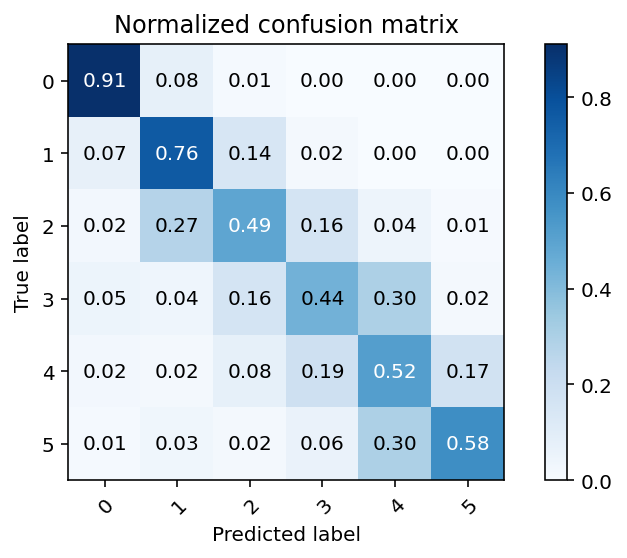

In [88]:
_ = plot_confusion_matrix(val_df.isup_grade, val_df.isup_pred, normalize=True)

In [89]:
logging.info(f"Models: {model_fnames}")

Models: ['03-07-2020-20-18_30_loss.pth']


In [90]:
pred_kappa = cohen_kappa_score(val_df.isup_grade, val_df.isup_pred, weights="quadratic")

In [91]:
logging.info(f"Overall kapa: {pred_kappa}")

Overall kapa: 0.8849877632621721


In [92]:
karol_df = val_df[val_df.data_provider == "karolinska"].copy()
kapa_karol = cohen_kappa_score(karol_df.isup_grade, karol_df.isup_pred, weights="quadratic")
logging.info(f"Karolinska kapa: {kapa_karol}")

Karolinska kapa: 0.8867675070275062


In [93]:
radboud_df = val_df[val_df.data_provider == "radboud"].copy()
kapa_radboud = cohen_kappa_score(radboud_df.isup_grade, radboud_df.isup_pred, weights="quadratic")
logging.info(f"Radboud kapa: {kapa_radboud}")

Radboud kapa: 0.8577989904242836


#### Optimize Rounding

In [94]:
rnd_sample_ids = val_df.sample(frac=0.5).index

In [95]:
val_df["eval"] = 0
val_df.loc[rnd_sample_ids, "eval"] = 1

In [96]:
dev_preds = val_df.loc[val_df["eval"] == 0, "isup_raw_pred"].values
dev_targs = val_df.loc[val_df["eval"] == 0, "isup_grade"].values
eval_preds = val_df.loc[val_df["eval"] == 1, "isup_raw_pred"].values
eval_targs = val_df.loc[val_df["eval"] == 1, "isup_grade"].values

In [97]:
opt_r = OptimizedRounder()
opt_r.fit(dev_preds, dev_targs)

In [98]:
coefficients = opt_r.coefficients()
logging.info(f"Optimized coefs: {coefficients}")

Optimized coefs: [0.50358551 1.55012698 2.55229496 3.51834579 4.50439696]


In [99]:
eval_preds_round = opt_r.predict(val_df.isup_raw_pred, coefficients)

In [100]:
round_opt_kapa = cohen_kappa_score(val_df.isup_grade, eval_preds_round, weights="quadratic")

In [101]:
logging.info(f"Optimized round kapa: {round_opt_kapa}")

Optimized round kapa: 0.8860918416261604


#### Check results with Hard Class Permutation

In [43]:
hard_cls_values = val_df.loc[val_df.isup_pred.isin([2,3,4]), "isup_pred"].copy().values

In [44]:
hard_cls_values[:5]

array([4, 3, 4, 2, 3])

In [45]:
np.random.shuffle(hard_cls_values)

In [46]:
hard_cls_values[:5]

array([3, 4, 3, 4, 2])

In [47]:
val_df.loc[val_df.isup_pred.isin([2,3,4]), "isup_pred"] = hard_cls_values

Normalized confusion matrix
[[0.94382022 0.03792135 0.00702247 0.00421348 0.00280899 0.00421348]
 [0.0830721  0.79937304 0.03605016 0.04702194 0.03291536 0.0015674 ]
 [0.04126984 0.27936508 0.25396825 0.22222222 0.18412698 0.01904762]
 [0.09310345 0.05862069 0.26896552 0.23793103 0.24482759 0.09655172]
 [0.0652921  0.03780069 0.26460481 0.25429553 0.2371134  0.14089347]
 [0.05818182 0.01454545 0.11636364 0.10545455 0.14909091 0.55636364]]


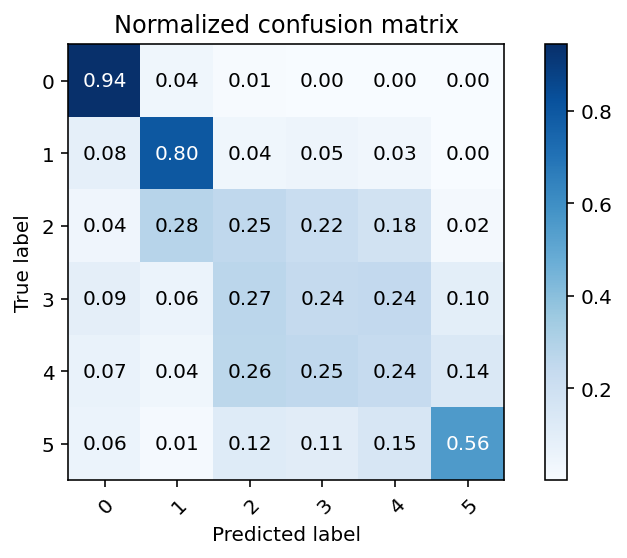

In [48]:
_ = plot_confusion_matrix(val_df.isup_grade, val_df.isup_pred, normalize=True)

In [49]:
permute_kapa = cohen_kappa_score(val_df.isup_grade, val_df.isup_pred, weights="quadratic")
permute_kapa

0.7659439769237075

In [50]:
print(f"Permutation importance: {1 - (permute_kapa/pred_kappa)}")

Permutation importance: 0.07017338008015972


In [34]:
# LB
print(f"LB Permutation importance: {1 - (0.80/0.84)}")

LB Permutation importance: 0.04761904761904756
